In [43]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Linear SVC with SGD

Load data

In [25]:
x_trn = pd.read_pickle("./data/x_train.pkl")
y_trn = pd.read_pickle("./data/y_train.pkl")
x_tst = pd.read_pickle("./data/x_test.pkl")
x_train_roc = pd.read_pickle("./data/x_train_roc.pkl")
y_train_roc = pd.read_pickle("./data/y_train_roc.pkl")
x_val_roc = pd.read_pickle("./data/x_val_roc.pkl")
y_val_roc = pd.read_pickle("./data/y_val_roc.pkl")

Set random seed

In [3]:
rng = np.random.RandomState(0)

Create cross-validation generator

In [4]:
cvg = StratifiedKFold(n_splits=5, shuffle=False)

Create an instance of the classifier we want to use

In [5]:
clf = SGDClassifier(loss='hinge', penalty='l2', random_state=rng)

Take a look at the parameters we'll need to create a grid for

In [6]:
clf.get_params(deep=False)

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': RandomState(MT19937) at 0x7FB7A010BC40,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Create parameter grid

In [7]:
param_grid = {'alpha':np.array([0.00005,0.0001, 0.0005, 0.005, 0.001, 0.01]), 'tol':np.array([0.0005, 0.005, 0.001, 0.01])}

Create successive halving grid search cross-validation estimator

In [52]:
search = HalvingGridSearchCV(estimator=clf, 
                             param_grid=param_grid, 
                             factor=2, 
                             cv=cvg, 
                             random_state=rng)
search.fit(x_trn, y_trn)
search.best_estimator_

SGDClassifier(alpha=0.001, random_state=RandomState(MT19937) at 0x7FB7D0100840,
              tol=0.005)

Create and save successive halving heatmap https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#

In [9]:
#TODO

Plot and save candidate scores over successive halving iterations https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html#

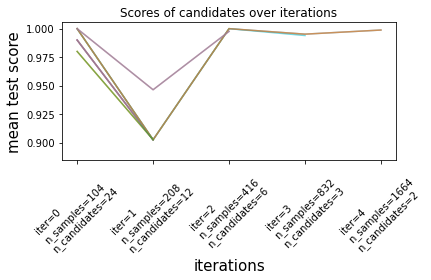

In [53]:
results = pd.DataFrame(search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={search.n_resources_[i]}\nn_candidates={search.n_candidates_[i]}"
    for i in range(search.n_iterations_)
]

ax.set_xticks(range(search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()
#TODO: save plot

Plot and save feature importance scores to determine top features https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [11]:
#TODO

Plot and save ROC curve https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions

0.9985063480209111

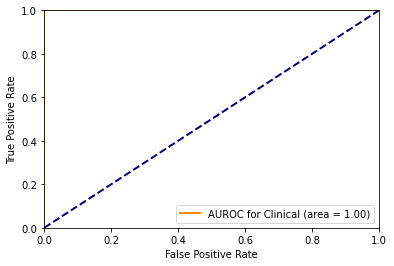

In [54]:
#TODO
#use RocCurveDisplay.from_predictions(y_true, y_pred)
clf_roc = SGDClassifier(loss='hinge', penalty='l2', random_state=rng)
clf_roc.set_params(**search.best_params_)
clf_roc.fit(x_train_roc, y_train_roc)
y_pred_roc = clf_roc.predict(x_val_roc)

fpr, tpr, _ = roc_curve(y_val_roc, y_pred_roc, pos_label=1)
roc_auc = auc(fpr, tpr)	

AUC = metrics.auc(fpr, tpr)
AUC

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUROC for Clinical (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

clf_roc.score(x_train_roc,y_train_roc)

Set classifier parameters to optimal values identified by cross-validation and fit on entire training set, then output predictions on test set

In [57]:
# Add loss = hinge/log (depending on model), and penalty = l2 to best params

clf.set_params(**search.best_params_) #check value, might need to join with params from block 4
clf.fit(x_trn, y_trn)
#we need to decide what to do with these predictions, since it's an unlabeled test set.
clf.score(x_trn, y_trn)

0.9994026284348865

In [22]:
y_pred = clf.predict(x_tst)
pickle.dump(y_pred,open("./data/y_pred_LinearSVC_SGD.pkl", "wb"))